In [1]:
%matplotlib inline

import os
import sys
import shap
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as itl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import clone
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from time import time
from datetime import datetime, timedelta
#from typing import Dict, List, Tuple, Any, Union, Optional

shap.initjs()

In [2]:
from cancer_package import preprocessing, constants, transformers, utilities
import cancer_package.reporters as reporters

In [3]:
NON_NAN_THRESH = .7
REPLACE_BY_NAN = False
N_FOLDS = 10

In [4]:
results_dirs = {
    "xgb_binary_energy": {
        "dir": "./results/xgb_binary_energy_20210324_1159",
        "info": {"multiple_categories": False, "use_energy_proteins": True}
    },
    "xgb_multi_energy": {
        "dir": "./results/xgb_multi_energy_20210326_0845",
        "info": {"multiple_categories": True, "use_energy_proteins": True}
    },
    "xgb_binary_no_energy": {
        "dir": "./results/xgb_binary_no_energy_20210327_1624",
        "info": {"multiple_categories": False, "use_energy_proteins": False}
    },
    "xgb_multi_no_energy": {
        "dir": "./results/xgb_multi_no_energy_20210327_0037",
        "info": {"multiple_categories": True, "use_energy_proteins": False}
    }
}

====== xgb_binary_energy =======
rm 22 proteins with no data


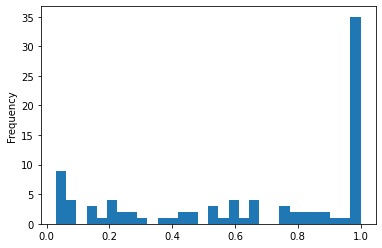

verification the transformation went fine
{0: 'cancer', 1: 'non-cancer'}
====== xgb_multi_energy =======
rm 22 proteins with no data


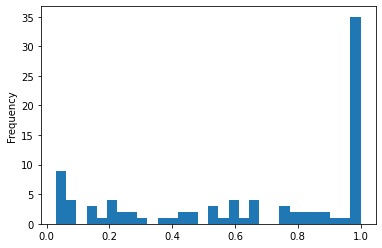

verification the transformation went fine
{1: 'CCA', 5: 'GC', 2: 'CRC', 7: 'LD', 3: 'CTL', 0: 'BC', 6: 'LC', 4: 'EC'}
====== xgb_binary_no_energy =======
rm 22 proteins with no data
rm 28 energy proteins


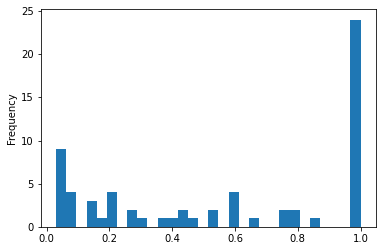

verification the transformation went fine
{0: 'cancer', 1: 'non-cancer'}
====== xgb_multi_no_energy =======
rm 22 proteins with no data
rm 28 energy proteins


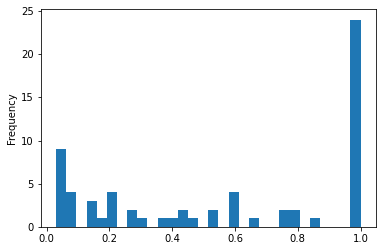

verification the transformation went fine
{1: 'CCA', 5: 'GC', 2: 'CRC', 7: 'LD', 3: 'CTL', 0: 'BC', 6: 'LC', 4: 'EC'}


In [5]:
DATA = {}
MODEL_RESULTS = {}
CLEAN_EQUATION_MAPPING = {}

for name, results_path in results_dirs.items():
    print(f"====== {name} =======")
    MODEL_RESULTS[name] = joblib.load(os.path.join(results_path["dir"], "model.pkl"))
    
    use_energy_proteins = results_path["info"]["use_energy_proteins"]
    multiple_categories = results_path["info"]["multiple_categories"]
    
    data = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
    formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))
    protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))

    data_prep = preprocessing.BasicPreprocessing(data, constants.NA_VALUE, use_energy_proteins)
    data_prep.organise_proteins(protein_group)
    data_prep.non_nan_share_hist(bins=30)
    data_prep.bio_features(formulas_df)
    data_prep.rm_execess_nans(NON_NAN_THRESH, by_group=False)

    DATA[name] = {}
    CLEAN_EQUATION_MAPPING.update(data_prep.clean_equation_mapping)
    data = shuffle(data_prep.data, random_state=69)
    DATA[name]["data"] = data
    DATA[name]["proteins"] = data_prep.proteins
    DATA[name]["formulas_df"] = data_prep.formulas_df
    feature_names = data_prep.feature_names()

    X, y = data[feature_names], data["category"]

    if multiple_categories:
        category_mapping = {('LD (COPD)', 'LD (PM)'): "LD"}
    else:
        category_mapping = {
            ('CTL', 'LD (COPD)', 'LD (PM)'): "non-cancer",
            ('GC', 'LC', 'CCA', 'CRC', 'BC', 'EC'): "cancer"
        }
    category_encoder = transformers.MapCategories( category_mapping)
    y = category_encoder.fit_transform(y)
    DATA[name]["category_encoder"] = category_encoder

    if REPLACE_BY_NAN:
        X.fillna(constants.NA_VALUE, inplace=True)
    
    DATA[name]["X"] = X
    DATA[name]["y"] = y

    print("verification the transformation went fine")
    print({i:category_encoder.inverse_transform(pd.Series([i]))[0] for i in y.unique()})
    category_encoder.inverse_transform( y).value_counts() / len(y)

In [6]:
best_features = {
    name: results["fs_features"][results["fs_scores"].idxmax()] 
    for name, results in MODEL_RESULTS.items()
}

#best_features

In [7]:
# accuracy and balanced accuracy for trivial estimator
from sklearn.metrics import balanced_accuracy_score

print(
    balanced_accuracy_score(
        DATA["xgb_binary_no_energy"]["y"],
        np.zeros_like(y),
        sample_weight=utilities.class_weights(DATA[name]["y"])
    )
)

from sklearn.metrics import accuracy_score
accuracy_score(
    DATA["xgb_binary_no_energy"]["y"],
    np.zeros_like(y),
    #sample_weight=utilities.class_weights(DATA[name]["y"])
)

0.5


0.683982683982684

In [8]:
MODEL_RESULTS['xgb_binary_energy']["fs_scores"]# == model_results['xgb_binary_energy']["fs_scores"].max()

225   -0.288608
224   -0.291560
223   -0.301077
219   -0.282847
217   -0.294645
dtype: float64

In [9]:
{name: len(features) for name, features in best_features.items()}

{'xgb_binary_energy': 219,
 'xgb_multi_energy': 75,
 'xgb_binary_no_energy': 26,
 'xgb_multi_no_energy': 45}

# Reporters



============  xgb_binary_energy  ================
1: 219
2: 219



cv f1-macro 83.29%
cv f1-micro 85.71%
cv accuracy score for best tree: 85.71%
cv balanced accuracy for best tree: 82.92%
cv confusion


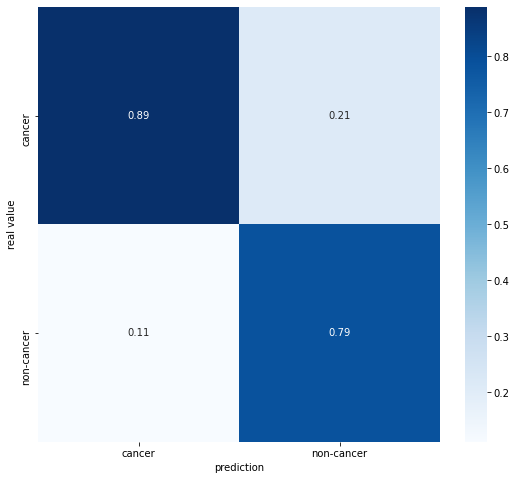

              precision    recall  f1-score   support

      cancer       0.89      0.91      0.90       158
  non-cancer       0.79      0.75      0.77        73

    accuracy                           0.86       231
   macro avg       0.84      0.83      0.83       231
weighted avg       0.86      0.86      0.86       231

recall by category




decision tree feature importance


importance of each individual feature (ordered)


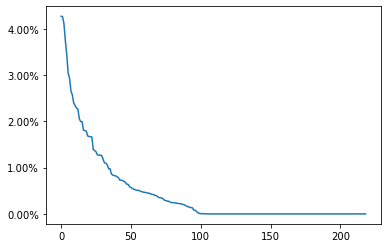

cumulative importance of each feature (ordered)


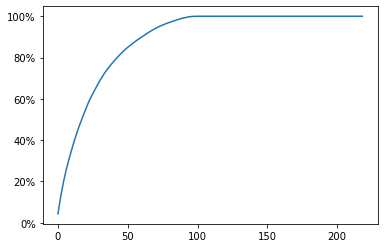



============  xgb_multi_energy  ================
1: 75
2: 75



cv f1-macro 58.19%
cv f1-micro 61.04%
cv accuracy score for best tree: 61.04%
cv balanced accuracy for best tree: 57.62%
cv confusion


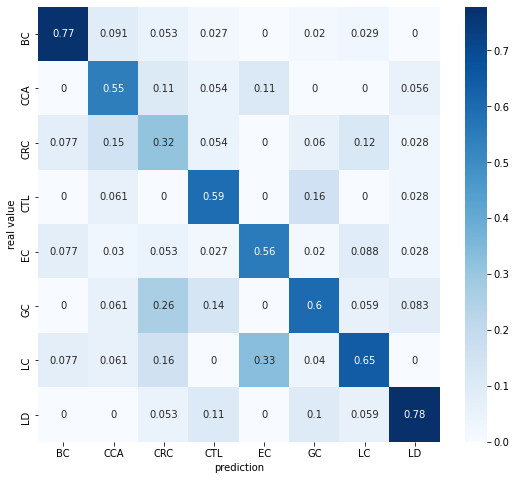

              precision    recall  f1-score   support

          BC       0.77      0.59      0.67        17
         CCA       0.55      0.72      0.62        25
         CRC       0.32      0.27      0.29        22
         CTL       0.59      0.67      0.63        33
          EC       0.56      0.36      0.43        14
          GC       0.60      0.64      0.62        47
          LC       0.65      0.67      0.66        33
          LD       0.78      0.70      0.74        40

    accuracy                           0.61       231
   macro avg       0.60      0.58      0.58       231
weighted avg       0.61      0.61      0.61       231

recall by category




decision tree feature importance


importance of each individual feature (ordered)


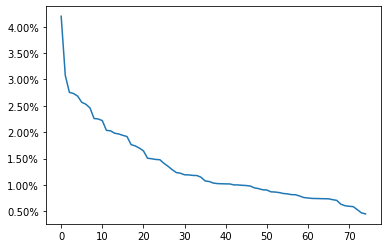

cumulative importance of each feature (ordered)


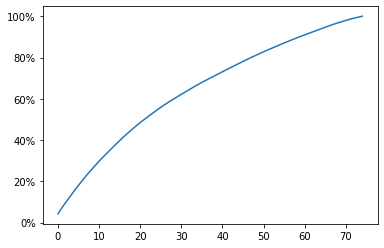



============  xgb_binary_no_energy  ================
1: 26
2: 26



cv f1-macro 84.87%
cv f1-micro 87.01%
cv accuracy score for best tree: 87.01%
cv balanced accuracy for best tree: 84.61%
cv confusion


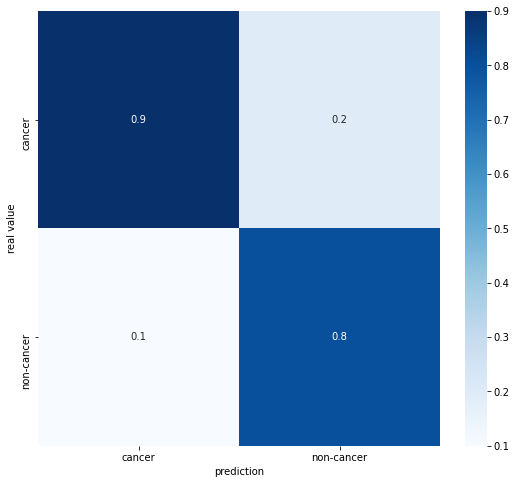

              precision    recall  f1-score   support

      cancer       0.90      0.91      0.91       158
  non-cancer       0.80      0.78      0.79        73

    accuracy                           0.87       231
   macro avg       0.85      0.85      0.85       231
weighted avg       0.87      0.87      0.87       231

recall by category




decision tree feature importance


importance of each individual feature (ordered)


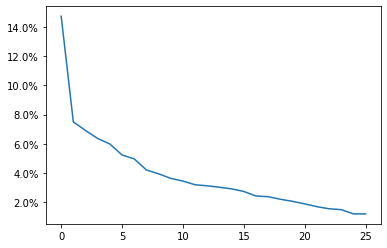

cumulative importance of each feature (ordered)


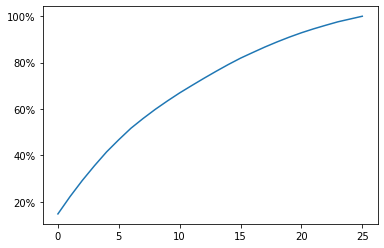



============  xgb_multi_no_energy  ================
1: 45
2: 45



cv f1-macro 48.02%
cv f1-micro 51.52%
cv accuracy score for best tree: 51.52%
cv balanced accuracy for best tree: 47.46%
cv confusion


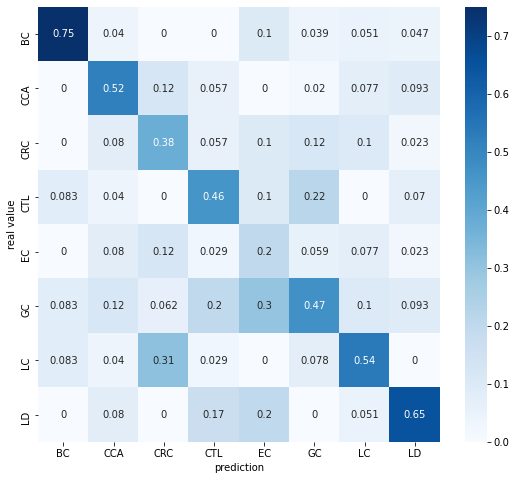

              precision    recall  f1-score   support

          BC       0.75      0.53      0.62        17
         CCA       0.52      0.52      0.52        25
         CRC       0.38      0.27      0.32        22
         CTL       0.46      0.48      0.47        33
          EC       0.20      0.14      0.17        14
          GC       0.47      0.51      0.49        47
          LC       0.54      0.64      0.58        33
          LD       0.65      0.70      0.67        40

    accuracy                           0.52       231
   macro avg       0.50      0.47      0.48       231
weighted avg       0.51      0.52      0.51       231

recall by category




decision tree feature importance


importance of each individual feature (ordered)


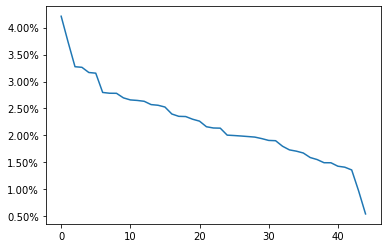

cumulative importance of each feature (ordered)


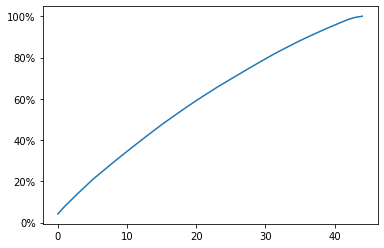

In [11]:
#import seaborn as sns
#sns.set(font_scale=2)

cv_splitter = StratifiedKFold(N_FOLDS, shuffle=False)

for name in DATA.keys():
    print(f"\n\n============  {name}  ================")
    best_score_idx = MODEL_RESULTS[name]["fs_scores"].idxmax()
    best_pipe = MODEL_RESULTS[name]["fs_pipes"][best_score_idx]
    best_features = MODEL_RESULTS[name]["fs_features"][best_score_idx]

    xgb_feat_imp = reporters.report_maker(
        best_pipe,
        DATA[name]["X"][best_features],
        DATA[name]["y"],
        X_test=None,
        y_test=None,
        category_names=DATA[name]["category_encoder"].classes_.tolist(),
        categories=data.category.to_list(),
        feature_codes=best_features.tolist(),
        equation_mapping=CLEAN_EQUATION_MAPPING,
        weight_array=utilities.class_weights(DATA[name]["y"]),
        cv=cv_splitter
    )

# Analysing which proteins are in model (directly or indirectly)

In [ ]:
"""
dummy_data = pd.DataFrame({'patient_id':[1,11], 'category':[2,22], "a":[3,33]})
formulas_df = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'formulas.csv'))

data_prep = preprocessing.BasicPreprocessing(dummy_data, constants.NA_VALUE)
data_prep.bio_feature_equations(formulas_df)
"""

In [14]:
def get_proteins_in_features(feature_names):
    clean_feature_names = pd.Series(feature_names).apply(lambda x: CLEAN_EQUATION_MAPPING.get(x, x))
    proteins_in_features = itl.chain(*clean_feature_names.str.findall(r'\w+').tolist())
    return  np.unique(list(proteins_in_features))


proteins_in_features = {}
for name, selected_model_results in MODEL_RESULTS.items():
    best_score_idx = selected_model_results["fs_scores"].idxmax()
    best_features = selected_model_results["fs_features"][best_score_idx]
    proteins_in_features[name] = get_proteins_in_features(best_features)

In [30]:
proteins_in_features_df = pd.concat(
    [
        pd.Series(len(proteins)*[True], index=proteins, name=name)
        for name, proteins in proteins_in_features.items()
        #if name != 'xgb_binary_energy'
    ],
    axis="columns"
).fillna(False)

sort_cols = ["xgb_binary_no_energy", "xgb_binary_energy", "xgb_multi_no_energy", "xgb_multi_energy"]
print("proteins in models")
with pd.option_context('display.max_rows', 100):
    display(
        proteins_in_features_df[sort_cols].sort_values(sort_cols, ascending=False)
    )

proteins in models


xgb_binary_no_energy  xgb_binary_energy  xgb_multi_no_energy  \
CCT2                      True               True                 True   
CCT5                      True               True                 True   
CCT7                      True               True                 True   
DNAJ                      True               True                 True   
DNAJA1                    True               True                 True   
DNAJA2                    True               True                 True   
DNAJB1                    True               True                 True   
DNAJC11                   True               True                 True   
DNAJC13                   True               True                 True   
DNAJC5                    True               True                 True   
FKBP4                     True               True                 True   
HSP70                     True               True                 True   
HSP90AA1                  True               True                 True   
HSP90AB1                  True               True                 True   
HSP90B1                   True               True                 True   
HSPA2                     True               True                 True   
HSPA6                     True               True                 True   
HSPA8                     True               True                 True   
HSPA9                     True               True                 True   
HSPB1                     True               True                 True   
PPP5C                     True               True                 True   
ST13                      True               True                 True   
STIP1                     True               True                 True   
STUB1                     True               True                 True   
TRAP1                     True               True                 True   
CCT3                      True               True                 True   
PPIF                      True               True                 True   
HSPA5                     True               True                False   
CCT8                      True               True                False   
CCT1                     False               True                 True   
CCT6A                    False               True                 True   
HSPA4                    False               True                 True   
HSPB4                    False               True                 True   
HSPB5                    False               True                 True   
HSPD1                    False               True                 True   
HSPH1                    False               True                 True   
CAT                      False               True                False   
FBP1                     False               True                False   
GCLC                     False               True                False   
GCLM                     False               True                False   
GGT1                     False               True                False   
GGT6                     False               True                False   
GSR                      False               True                False   
GSS                      False               True                False   
GSTA1                    False               True                False   
GSTA2                    False               True                False   
GSTK1                    False               True                False   
GSTM3                    False               True                False   
GSTP1                    False               True                False   
GSTZ1                    False               True                False   
HSP90                    False               True                False   
HSPA12A                  False               True                False   
SDHA                     False               True                False   
SDHB          

In [ ]:
proteins_in_features_df[~proteins_in_features_df.index.isin(constants.ENERGY_PROTEINS)].sum(1).value_counts()

# SHAP

In [ ]:
#! pip install shap==0.39

In [31]:
def logloss(true_label, predicted, n_classes, eps=1e-15):
    dummy = np.repeat(0, n_classes)
    dummy[true_label] = 1
    return log_loss(dummy, predicted)

In [32]:
def best_worst_preds(model, X, y, category_encoder, cv):
    n_categories = len(category_encoder.classes_)
    y_pred_prob = cross_val_predict(clone(model), X, y, cv=cv, method='predict_proba')

    pred_prob_df = pd.DataFrame(
        y_pred_prob,
        columns=category_encoder.classes_,
        index=y.index
    )
    pred_prob_df["y_pred"] = pred_prob_df.idxmax(1)
    pred_prob_df["y_code"] = y
    pred_prob_df["y"] = category_encoder.inverse_transform(y)
    pred_prob_df["correct_pred"] = pred_prob_df["y"] == pred_prob_df["y_pred"]
    pred_prob_df["log_loss"] = pred_prob_df.apply(
        lambda row: logloss(row["y_code"], row[category_encoder.classes_], n_categories),
        axis=1
    )

    return pred_prob_df.drop("y_code", axis=1)

In [93]:
SHAP_DIR = os.path.join(os.getcwd(), "result_plots")

def display_force_plot_and_comments(
        explainer,
        shap_values,
        X_patient,
        performance_info,
        category_encoder,
        save_name):
    n_classes = len(category_encoder.classes_)
    # predict proba case
    y_patient = performance_info['y']
    y_pred_patient = performance_info['y_pred']
    if n_classes > 0: #n_classes > 2:
        y_code = category_encoder.transform(pd.Series(y_patient))[0]
        y_pred_code = category_encoder.transform(pd.Series(y_pred_patient))[0]
        exp_value = explainer.expected_value
    else:
        y_pred_code = 0
        exp_value = [explainer.expected_value]
    print(f"y == {y_patient}, y_code == {y_code}")
    print(f"y_pred == {y_pred_patient}, y_code == {y_pred_code}")

    if performance_info["correct_pred"]:
        print(
            f"model correctly predicted {y_patient} (p={performance_info[y_patient]:.2%})",
            f" -- log loss {performance_info['log_loss']:.3}"
        )
    else:
        print(
            f"model predicted {y_pred_patient} (p={performance_info[y_pred_patient]:.2%}) ", 
            f"when in fact it was {y_patient} (p={performance_info[y_patient]:.2%}) ",
            f"-- log loss {performance_info['log_loss']:.3}"
        )
        print("SHAP - prediction made (wrong category)")

    display(
        shap.force_plot(
            exp_value[y_pred_code],
            # predict proba case
            shap_values[y_pred_code], #shap_values[y_pred_code,:],
            X_patient.rename(columns=CLEAN_EQUATION_MAPPING).round(2),
            matplotlib=True,
            show=False if save_name else True,
            text_rotation=25
        )
    )
    if save_name:
        plt.savefig(
            os.path.join(SHAP_DIR, save_name, f"shap_force_actual_y_{y_patient}_pred_{y_pred_patient}.png"),
            dpi=300
        )
    
    if not performance_info["correct_pred"]:# and n_classes > 2:
        print("SHAP - prediction not made (correct category)")
        display(
            shap.force_plot(
                exp_value[y_code],
                # predict proba case
                shap_values[y_code], #shap_values[y_pred_code,:],
                X_patient.rename(columns=CLEAN_EQUATION_MAPPING).round(2),
                matplotlib=True,
                show=False if save_name else True,
                text_rotation=25
            )
        )
    
    if save_name:
        plt.savefig(
            os.path.join(SHAP_DIR, save_name, f"shap_force_actual_y_{y_patient}_pred_{y_pred_patient}.png"),
            dpi=300
        )

        
def best_worst_force_plots(best_model, X, y, best_worst, category_encoder, cv, save_name=None):
    for row_id, row in best_worst.iterrows():
        print(f"row_id {row_id}")
        X_patient = X.loc[[row_id]]
        row_number = X.index.get_loc(row_id)
        train_rownum, test_rownum = [
            (train_rownum, test_rownum) for train_rownum, test_rownum 
            in cv_splitter.split(DATA[name]["X"], DATA[name]["y"])
            if row_number in test_rownum
        ][0]
        
        model = clone(best_model).fit(X.iloc[train_rownum], y.iloc[train_rownum]) 
        if len(category_encoder.classes_) == 2:
            explainer = shap.TreeExplainer(model, data=X, model_output='predict_proba')
        else:
            explainer = shap.TreeExplainer(model, data=X)
        shap_values = explainer.shap_values(X_patient)
        
        display_force_plot_and_comments(explainer, shap_values, X_patient, row, category_encoder, save_name)



==========   xgb_binary_no_energy   ==========
row_id 127
y == cancer, y_code == 0
y_pred == cancer, y_code == 0
model correctly predicted cancer (p=99.85%)  -- log loss 0.00147


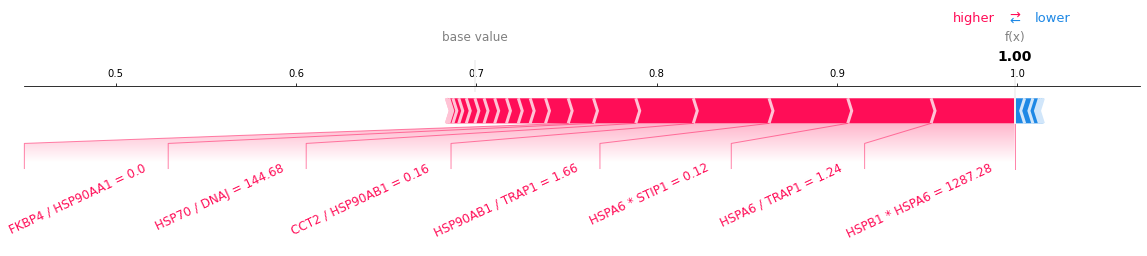

None

row_id 188
y == cancer, y_code == 0
y_pred == non-cancer, y_code == 1
model predicted non-cancer (p=88.02%)  when in fact it was cancer (p=11.98%)  -- log loss 2.12
SHAP - prediction made (wrong category)


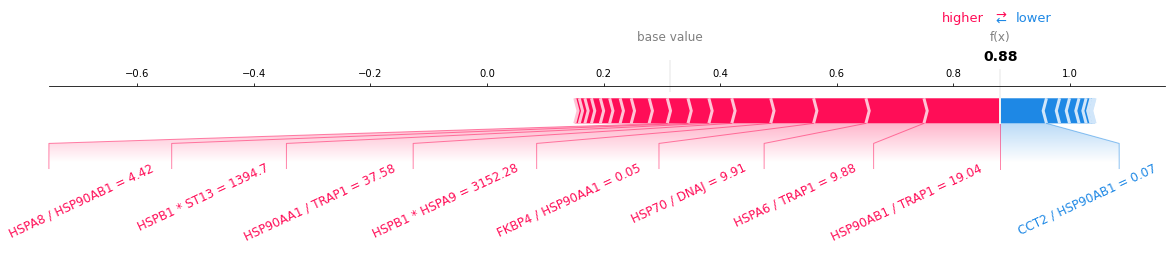

None

SHAP - prediction not made (correct category)


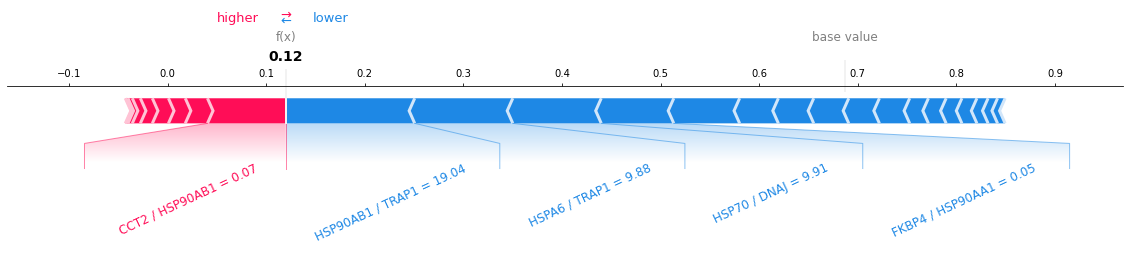

None

row_id 206
y == non-cancer, y_code == 1
y_pred == non-cancer, y_code == 1
model correctly predicted non-cancer (p=99.43%)  -- log loss 0.00576


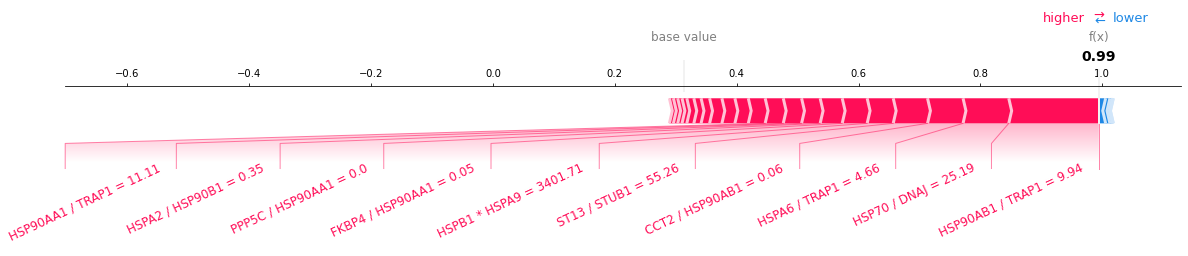

None

row_id 7
y == non-cancer, y_code == 1
y_pred == cancer, y_code == 0
model predicted cancer (p=98.87%)  when in fact it was non-cancer (p=1.13%)  -- log loss 4.48
SHAP - prediction made (wrong category)


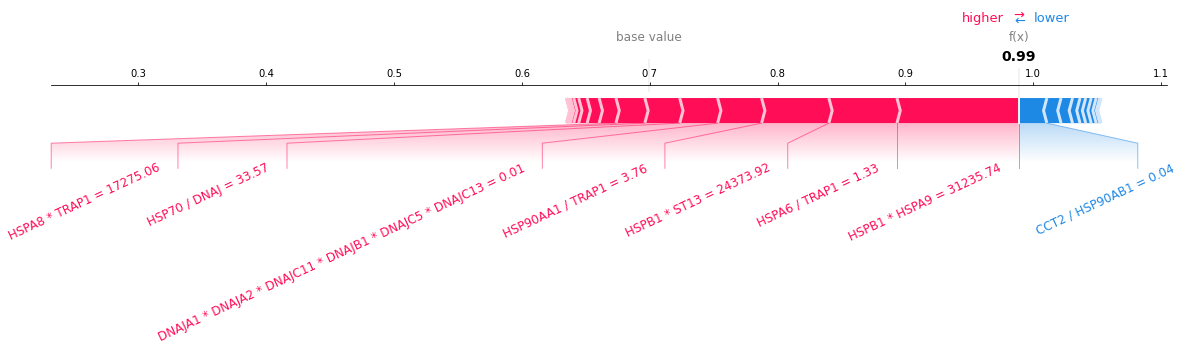

None

SHAP - prediction not made (correct category)


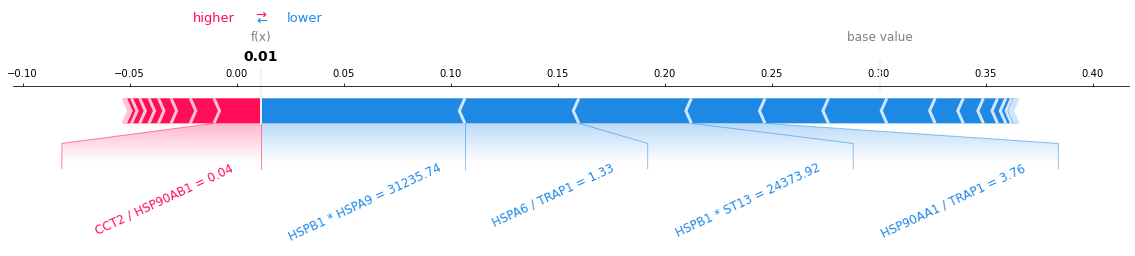

None



==========   xgb_multi_no_energy   ==========
row_id 73
y == BC, y_code == 0
y_pred == BC, y_code == 0
model correctly predicted BC (p=81.03%)  -- log loss 0.0503


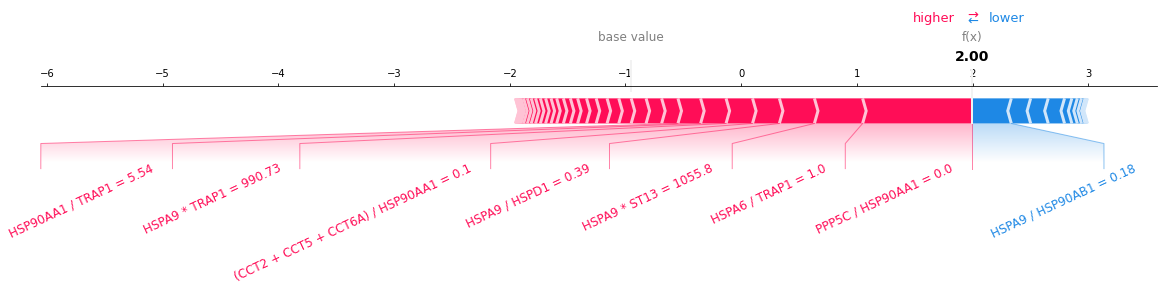

None

row_id 79
y == BC, y_code == 0
y_pred == GC, y_code == 5
model predicted GC (p=22.67%)  when in fact it was BC (p=4.17%)  -- log loss 0.528
SHAP - prediction made (wrong category)


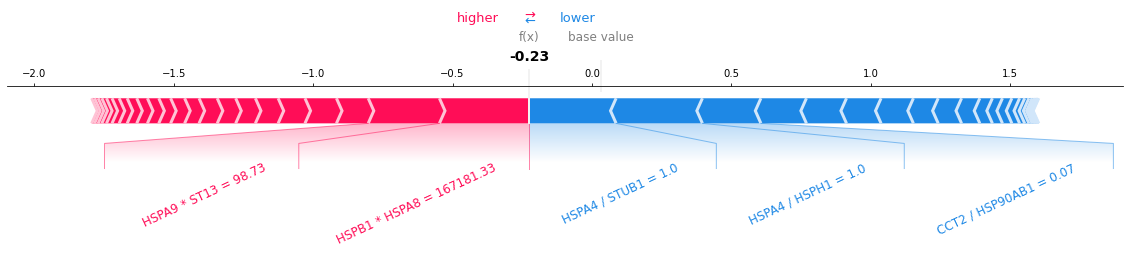

None

SHAP - prediction not made (correct category)


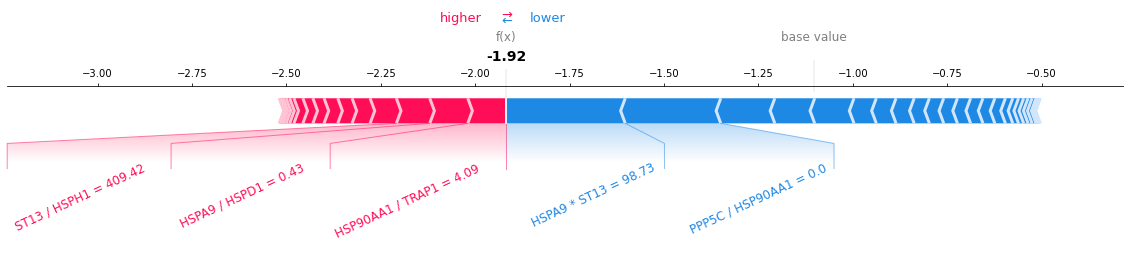

None

row_id 100
y == CCA, y_code == 1
y_pred == CCA, y_code == 1
model correctly predicted CCA (p=94.52%)  -- log loss 0.014


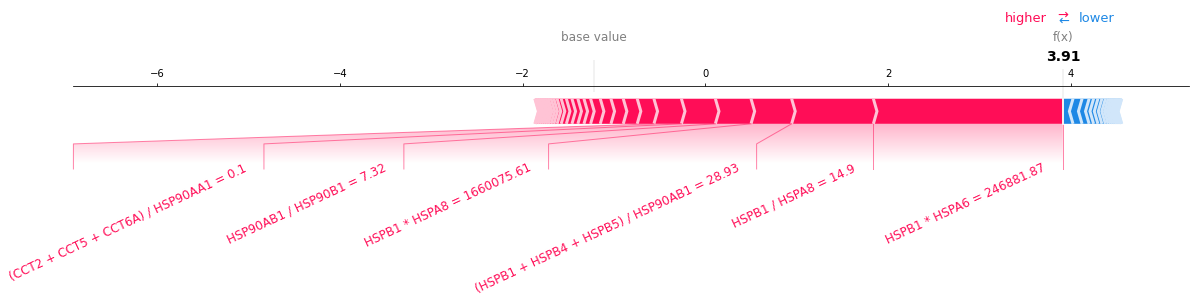

None

row_id 102
y == CCA, y_code == 1
y_pred == CTL, y_code == 3
model predicted CTL (p=86.47%)  when in fact it was CCA (p=2.87%)  -- log loss 0.707
SHAP - prediction made (wrong category)


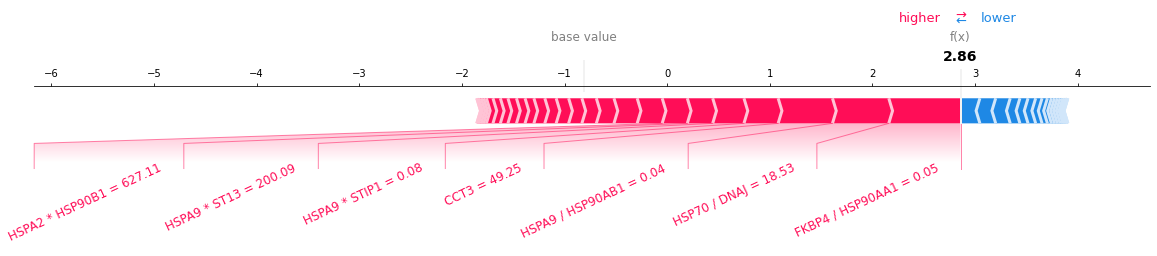

None

SHAP - prediction not made (correct category)


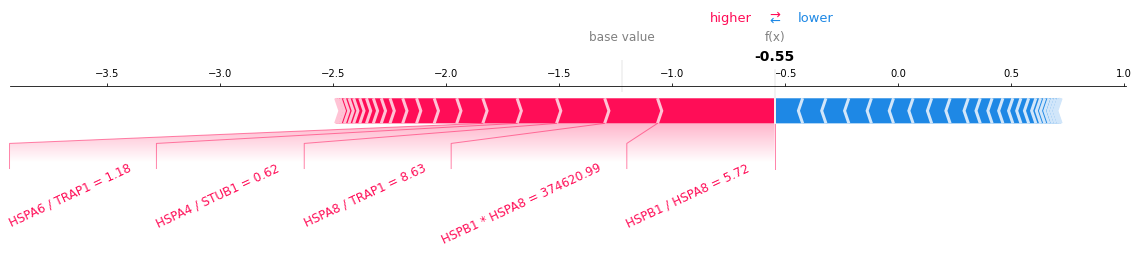

None

row_id 123
y == CRC, y_code == 2
y_pred == CRC, y_code == 2
model correctly predicted CRC (p=57.11%)  -- log loss 0.129


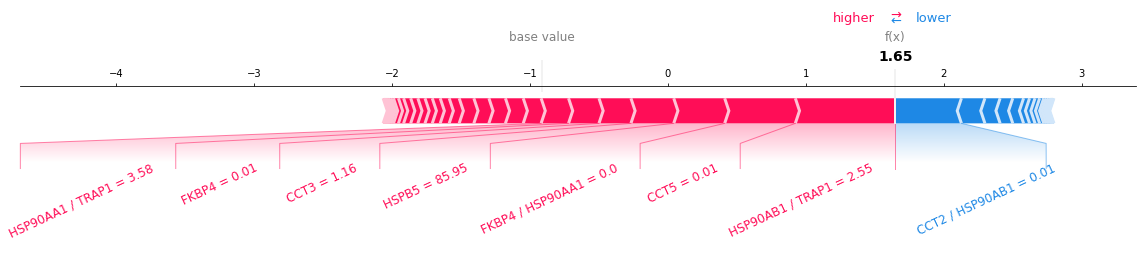

None

row_id 124
y == CRC, y_code == 2
y_pred == GC, y_code == 5
model predicted GC (p=93.10%)  when in fact it was CRC (p=1.58%)  -- log loss 0.86
SHAP - prediction made (wrong category)


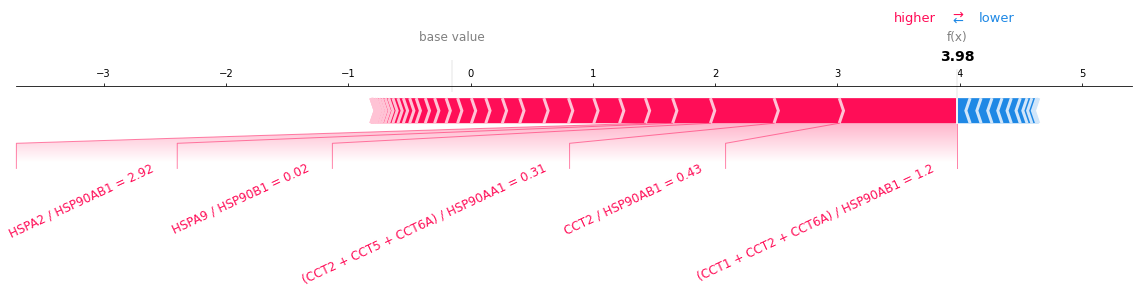

None

SHAP - prediction not made (correct category)


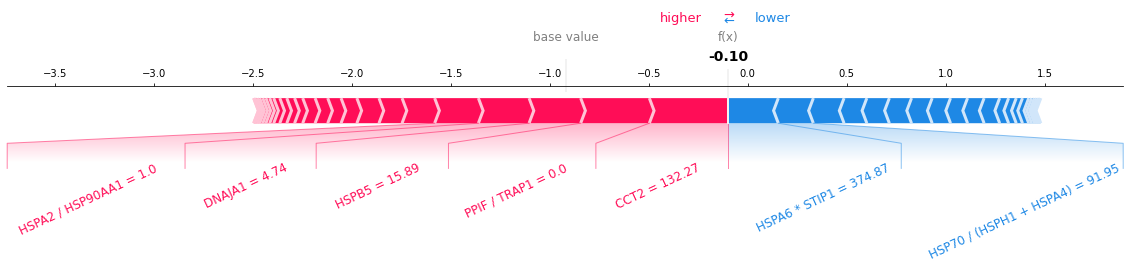

None

row_id 30
y == CTL, y_code == 3
y_pred == CTL, y_code == 3
model correctly predicted CTL (p=97.88%)  -- log loss 0.00533


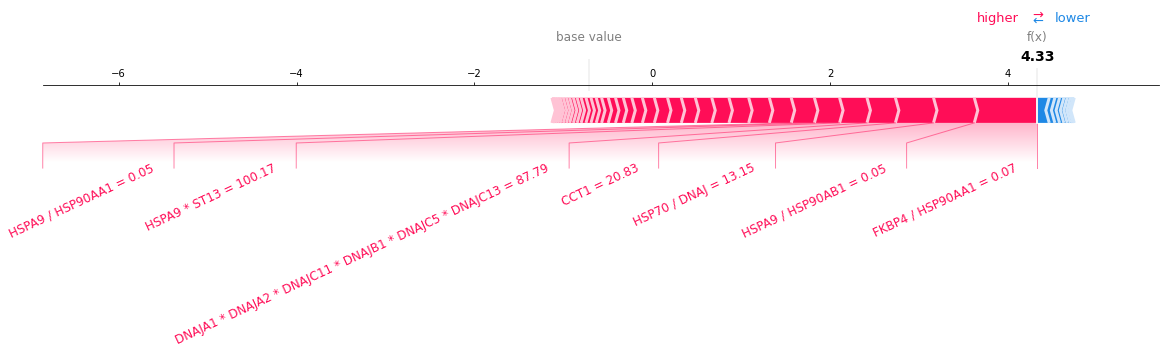

None

row_id 26
y == CTL, y_code == 3
y_pred == GC, y_code == 5
model predicted GC (p=94.64%)  when in fact it was CTL (p=1.25%)  -- log loss 0.918
SHAP - prediction made (wrong category)


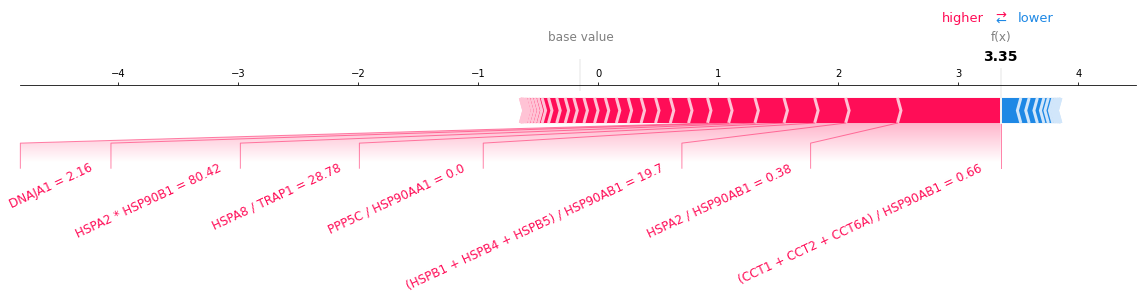

None

SHAP - prediction not made (correct category)


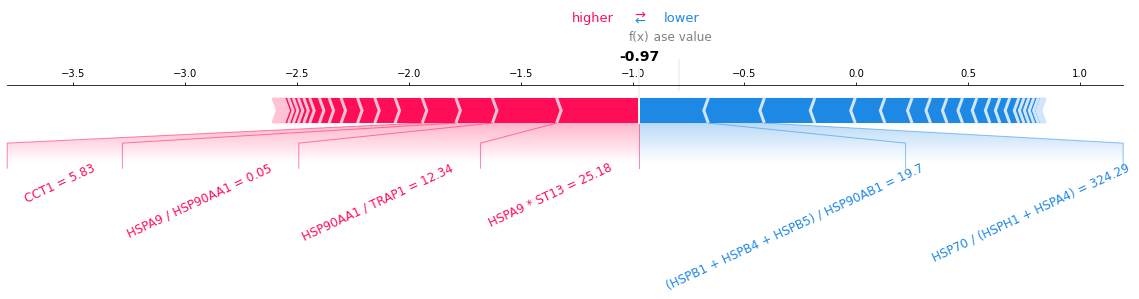

None

row_id 132
y == EC, y_code == 4
y_pred == EC, y_code == 4
model correctly predicted EC (p=64.11%)  -- log loss 0.102


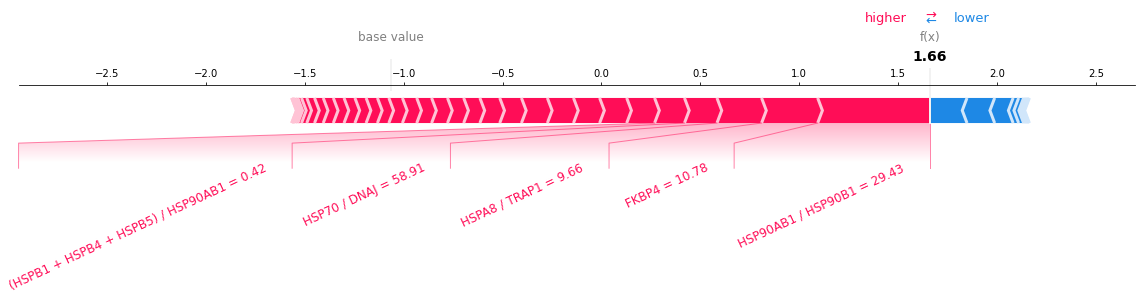

None

row_id 143
y == EC, y_code == 4
y_pred == GC, y_code == 5
model predicted GC (p=74.07%)  when in fact it was EC (p=0.95%)  -- log loss 0.784
SHAP - prediction made (wrong category)


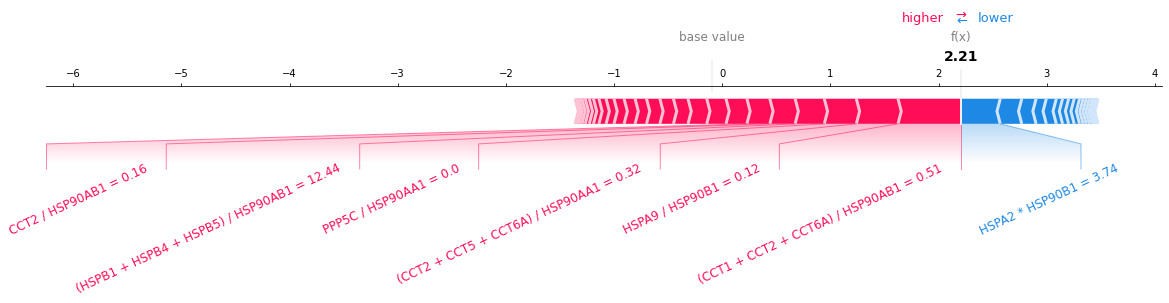

None

SHAP - prediction not made (correct category)


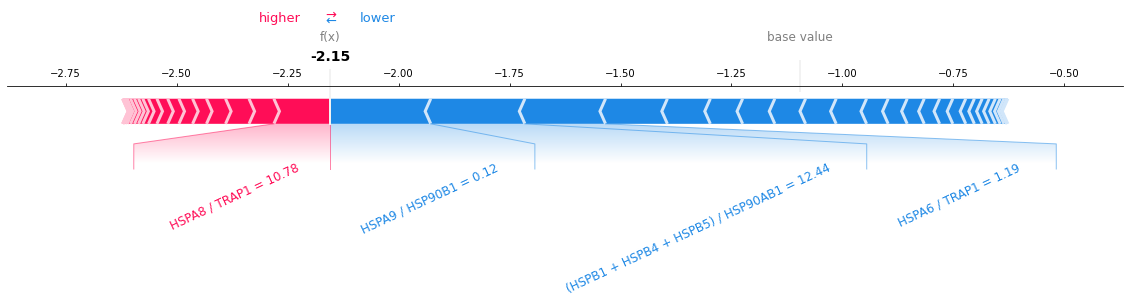

None

row_id 171
y == GC, y_code == 5
y_pred == GC, y_code == 5
model correctly predicted GC (p=95.56%)  -- log loss 0.0113


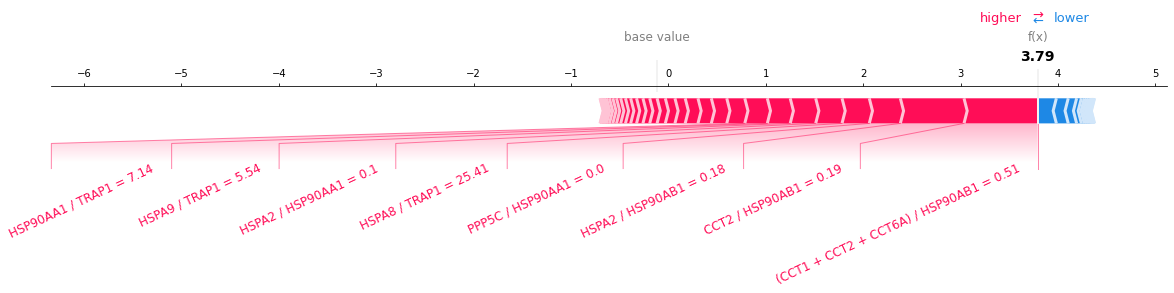

None

row_id 148
y == GC, y_code == 5
y_pred == CCA, y_code == 1
model predicted CCA (p=83.11%)  when in fact it was GC (p=4.03%)  -- log loss 0.64
SHAP - prediction made (wrong category)


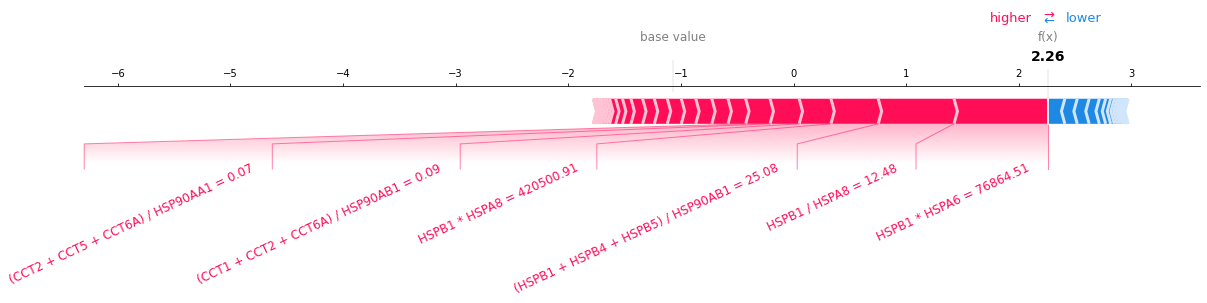

None

SHAP - prediction not made (correct category)


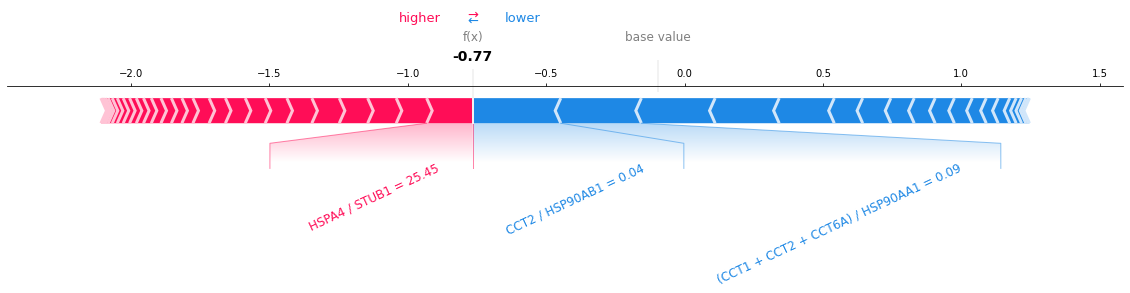

None

row_id 54
y == LC, y_code == 6
y_pred == LC, y_code == 6
model correctly predicted LC (p=93.68%)  -- log loss 0.0161


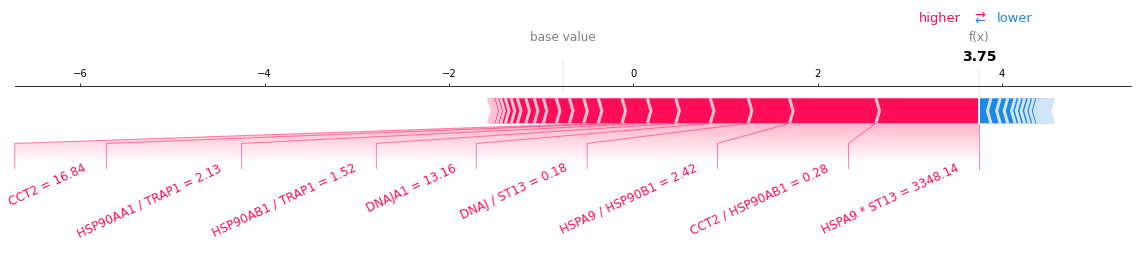

None

row_id 44
y == LC, y_code == 6
y_pred == CCA, y_code == 1
model predicted CCA (p=80.82%)  when in fact it was LC (p=4.56%)  -- log loss 0.611
SHAP - prediction made (wrong category)


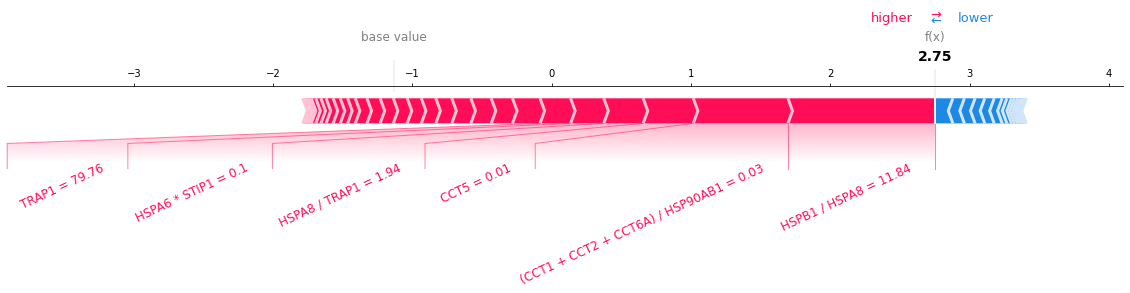

None

SHAP - prediction not made (correct category)


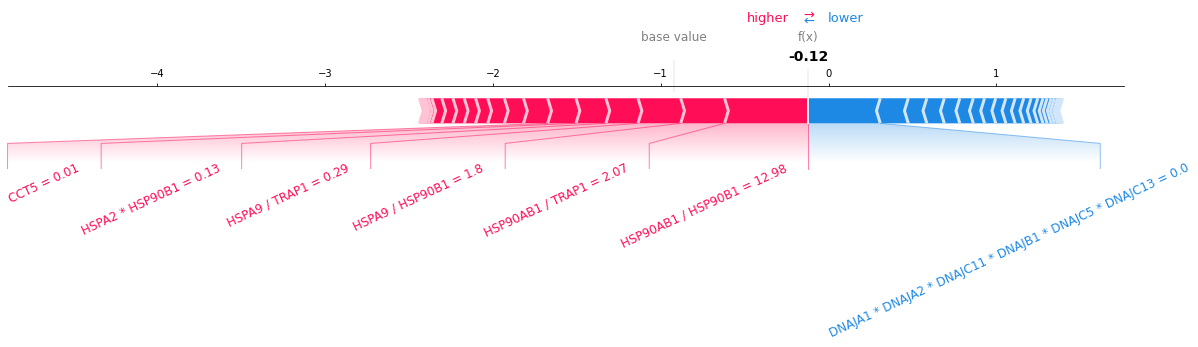

None

row_id 198
y == LD, y_code == 7
y_pred == LD, y_code == 7
model correctly predicted LD (p=98.84%)  -- log loss 0.00291


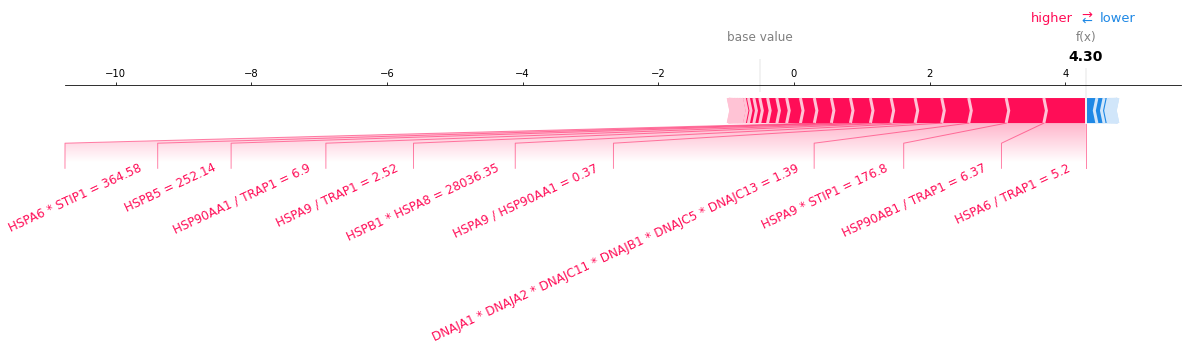

None

row_id 229
y == LD, y_code == 7
y_pred == CTL, y_code == 3
model predicted CTL (p=60.93%)  when in fact it was LD (p=3.17%)  -- log loss 0.596
SHAP - prediction made (wrong category)


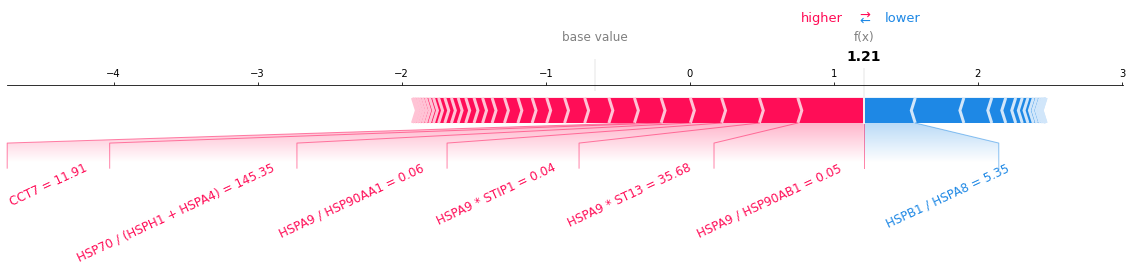

None

SHAP - prediction not made (correct category)


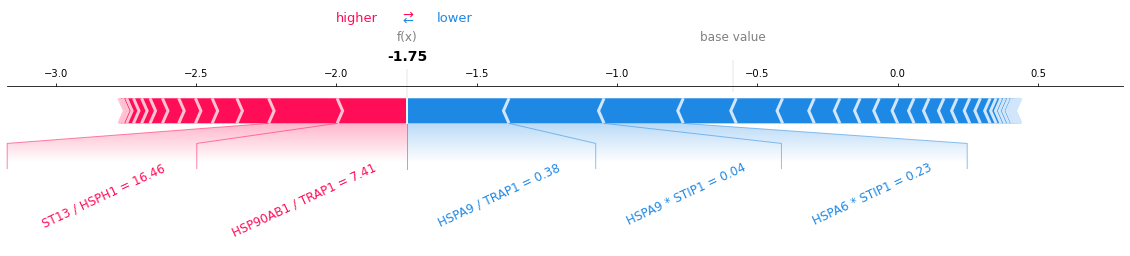

None



==========   xgb_multi_energy   ==========
row_id 73
y == BC, y_code == 0
y_pred == BC, y_code == 0
model correctly predicted BC (p=83.89%)  -- log loss 0.0425


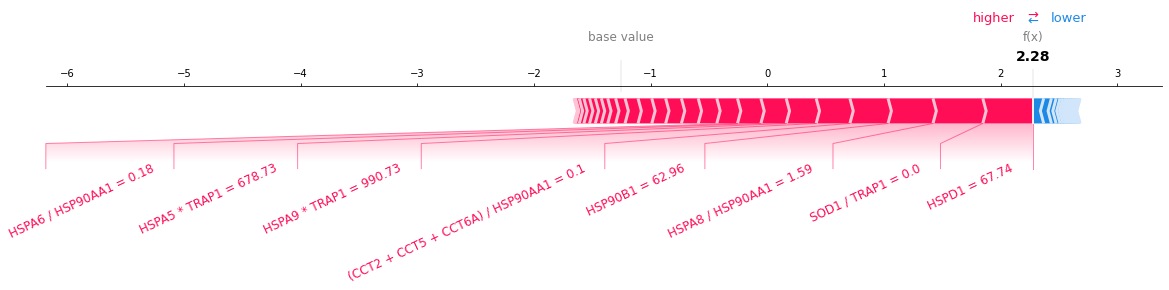

None

row_id 79
y == BC, y_code == 0
y_pred == CCA, y_code == 1
model predicted CCA (p=52.61%)  when in fact it was BC (p=1.89%)  -- log loss 0.649
SHAP - prediction made (wrong category)


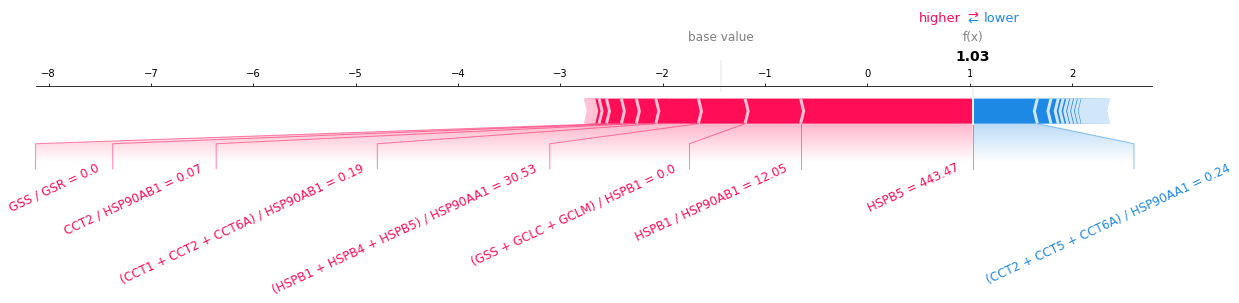

None

SHAP - prediction not made (correct category)


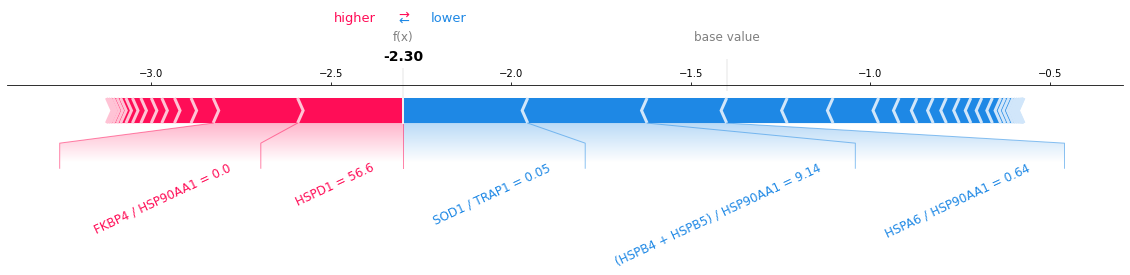

None

row_id 96
y == CCA, y_code == 1
y_pred == CCA, y_code == 1
model correctly predicted CCA (p=90.97%)  -- log loss 0.0232


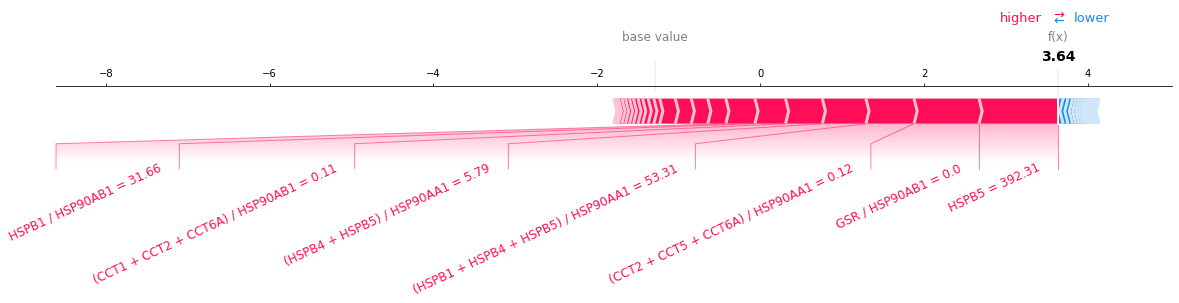

None

row_id 102
y == CCA, y_code == 1
y_pred == CTL, y_code == 3
model predicted CTL (p=79.67%)  when in fact it was CCA (p=2.18%)  -- log loss 0.701
SHAP - prediction made (wrong category)


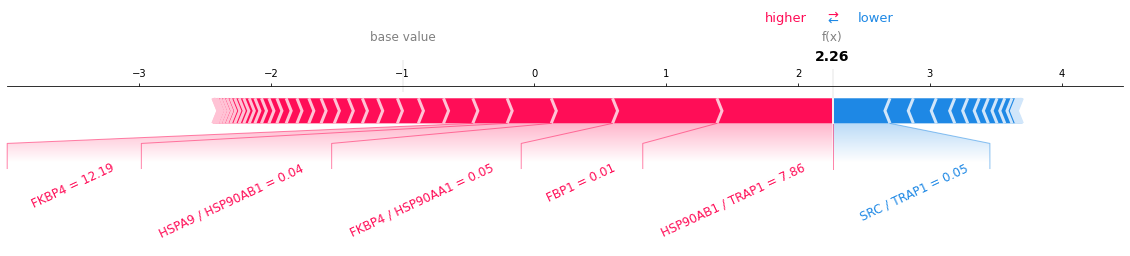

None

SHAP - prediction not made (correct category)


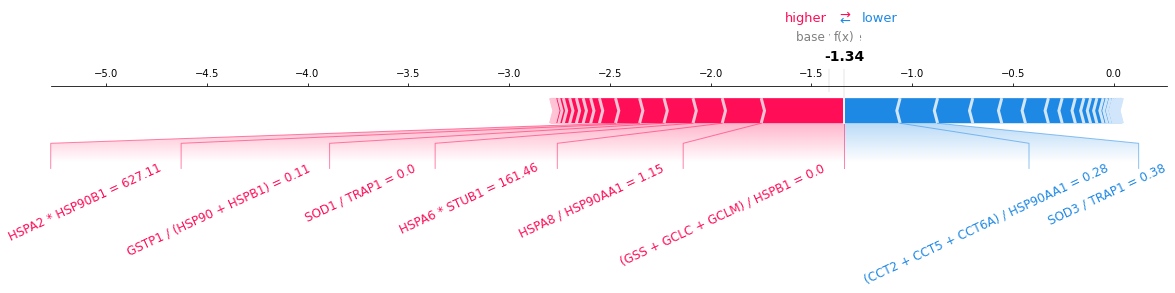

None

row_id 109
y == CRC, y_code == 2
y_pred == CRC, y_code == 2
model correctly predicted CRC (p=91.71%)  -- log loss 0.0213


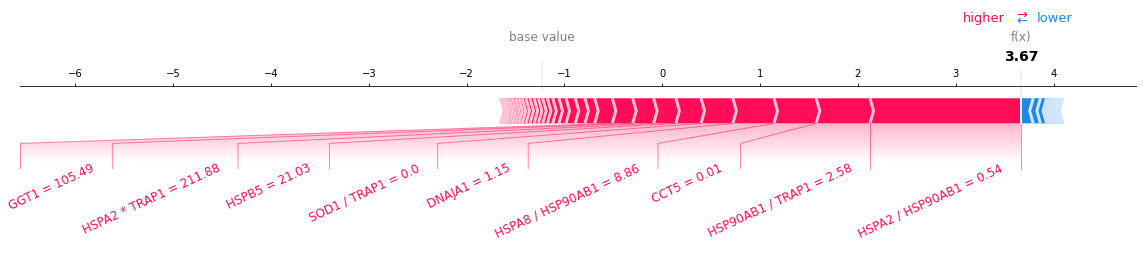

None

row_id 121
y == CRC, y_code == 2
y_pred == CCA, y_code == 1
model predicted CCA (p=85.85%)  when in fact it was CRC (p=1.19%)  -- log loss 0.815
SHAP - prediction made (wrong category)


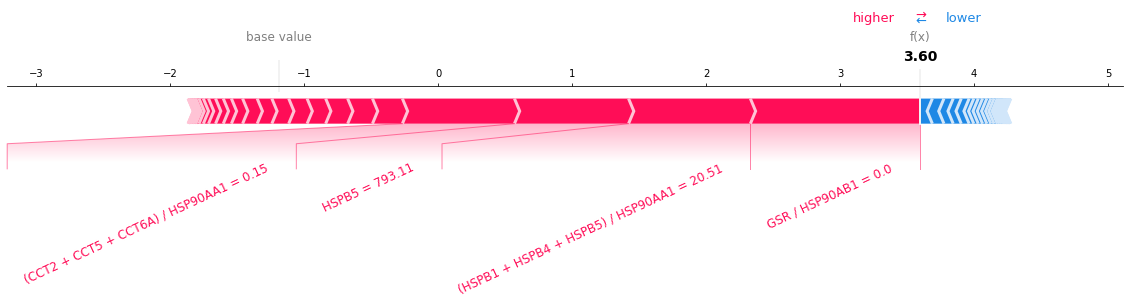

None

SHAP - prediction not made (correct category)


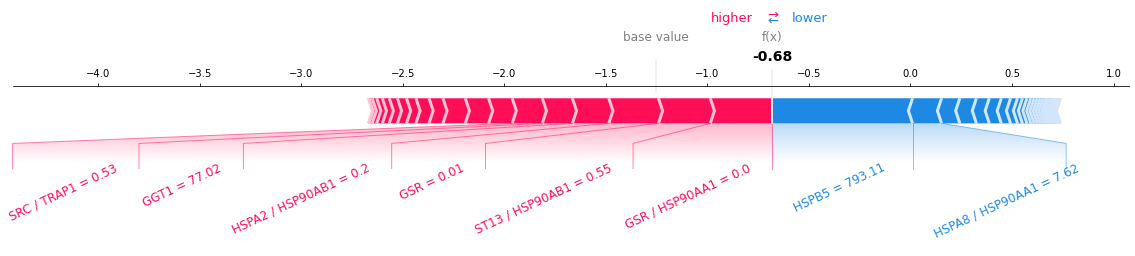

None

row_id 31
y == CTL, y_code == 3
y_pred == CTL, y_code == 3
model correctly predicted CTL (p=93.67%)  -- log loss 0.0162


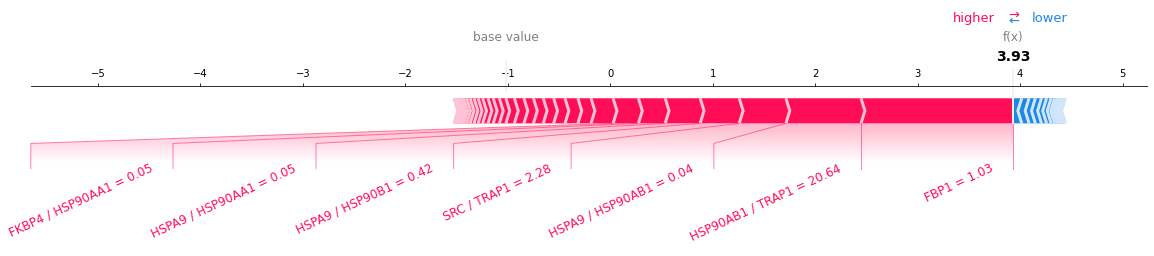

None

row_id 1
y == CTL, y_code == 3
y_pred == GC, y_code == 5
model predicted GC (p=89.29%)  when in fact it was CTL (p=4.39%)  -- log loss 0.678
SHAP - prediction made (wrong category)


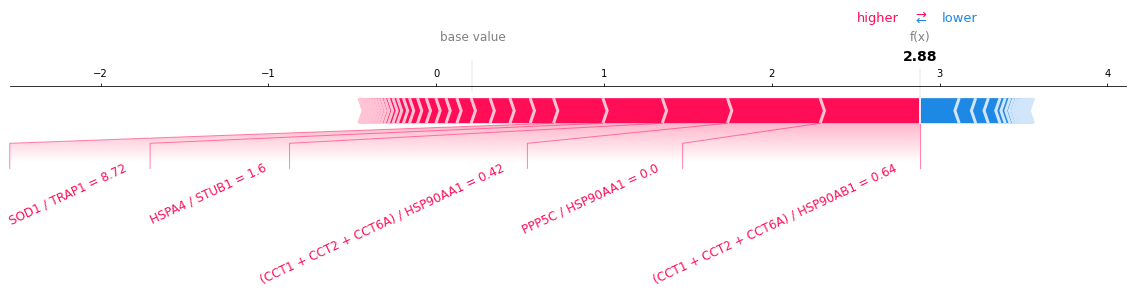

None

SHAP - prediction not made (correct category)


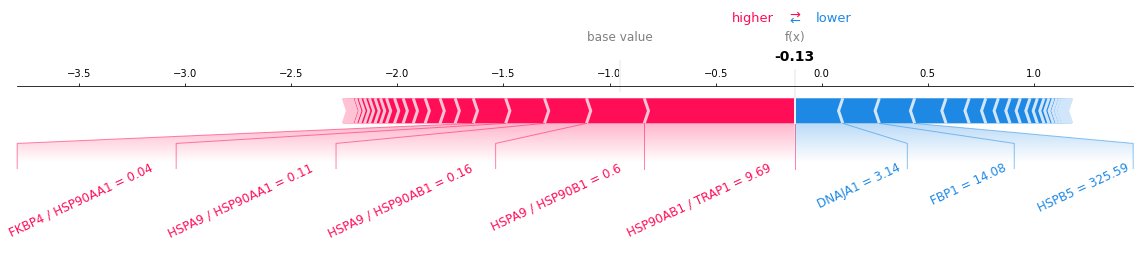

None

row_id 137
y == EC, y_code == 4
y_pred == EC, y_code == 4
model correctly predicted EC (p=78.82%)  -- log loss 0.0578


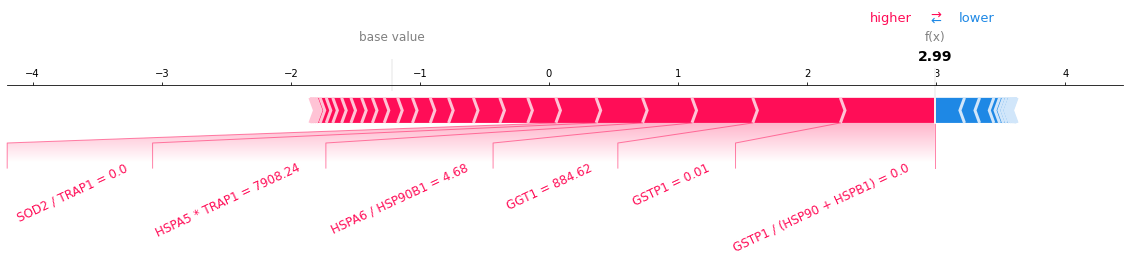

None

row_id 143
y == EC, y_code == 4
y_pred == GC, y_code == 5
model predicted GC (p=44.27%)  when in fact it was EC (p=1.20%)  -- log loss 0.705
SHAP - prediction made (wrong category)


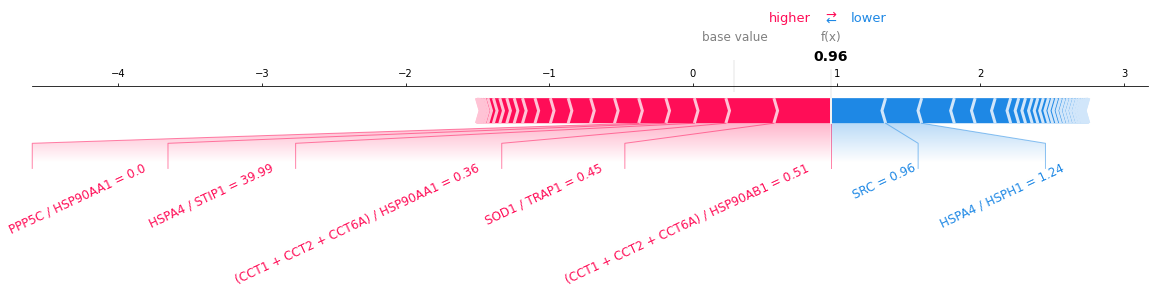

None

SHAP - prediction not made (correct category)


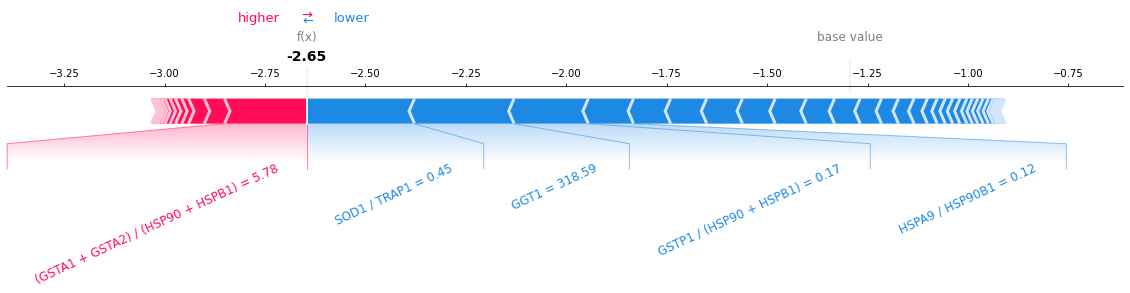

None

row_id 162
y == GC, y_code == 5
y_pred == GC, y_code == 5
model correctly predicted GC (p=96.97%)  -- log loss 0.00764


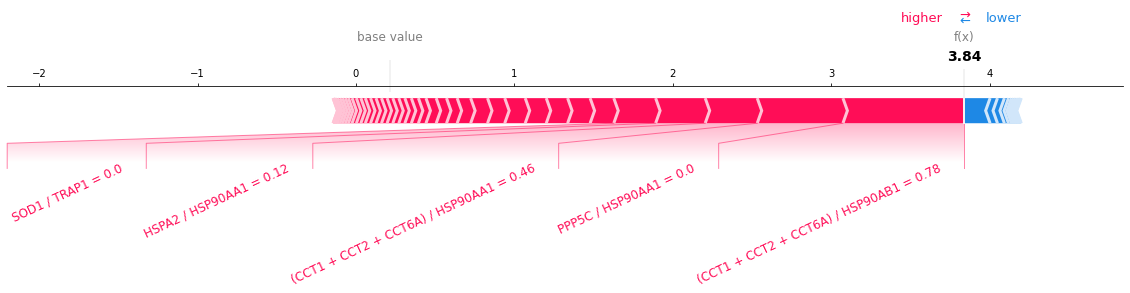

None

row_id 183
y == GC, y_code == 5
y_pred == CTL, y_code == 3
model predicted CTL (p=88.01%)  when in fact it was GC (p=4.06%)  -- log loss 0.676
SHAP - prediction made (wrong category)


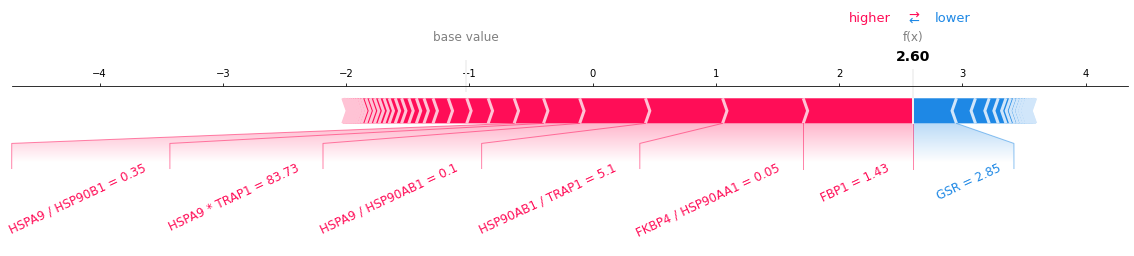

None

SHAP - prediction not made (correct category)


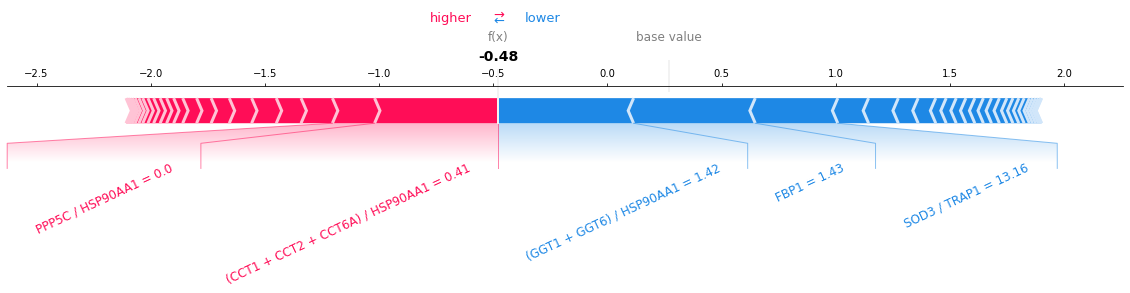

None

row_id 53
y == LC, y_code == 6
y_pred == LC, y_code == 6
model correctly predicted LC (p=94.21%)  -- log loss 0.0148


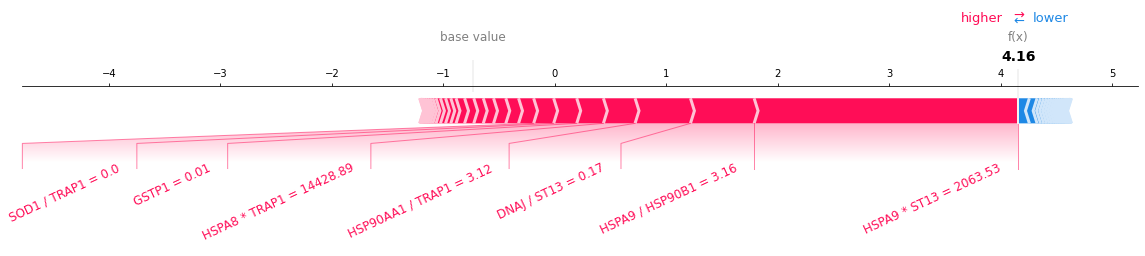

None

row_id 43
y == LC, y_code == 6
y_pred == GC, y_code == 5
model predicted GC (p=91.02%)  when in fact it was LC (p=1.36%)  -- log loss 0.848
SHAP - prediction made (wrong category)


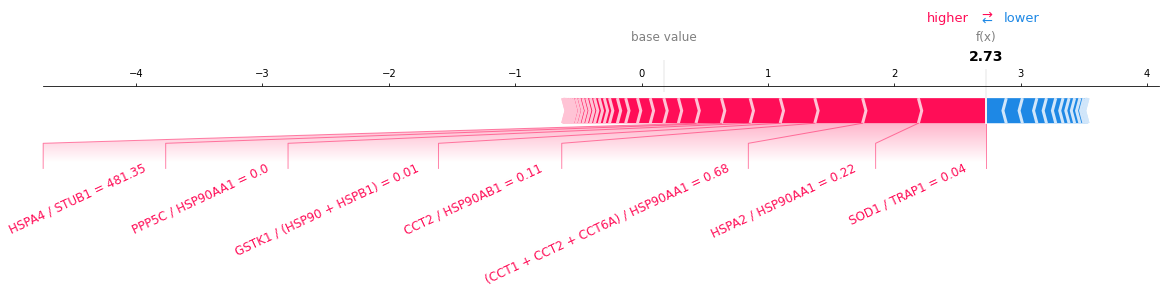

None

SHAP - prediction not made (correct category)


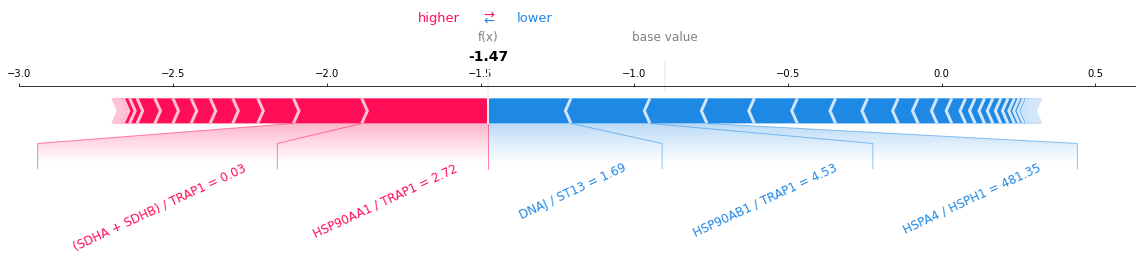

None

row_id 198
y == LD, y_code == 7
y_pred == LD, y_code == 7
model correctly predicted LD (p=99.45%)  -- log loss 0.00138


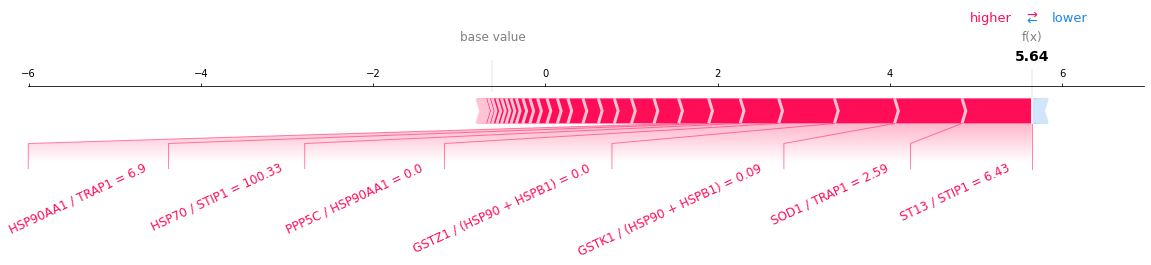

None

row_id 229
y == LD, y_code == 7
y_pred == CTL, y_code == 3
model predicted CTL (p=74.30%)  when in fact it was LD (p=5.42%)  -- log loss 0.562
SHAP - prediction made (wrong category)


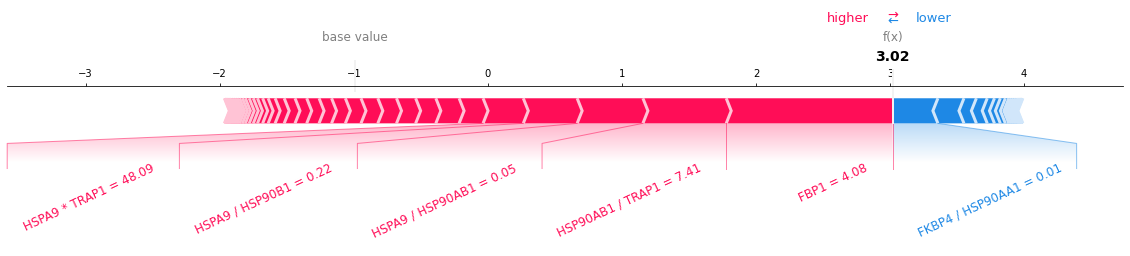

None

SHAP - prediction not made (correct category)


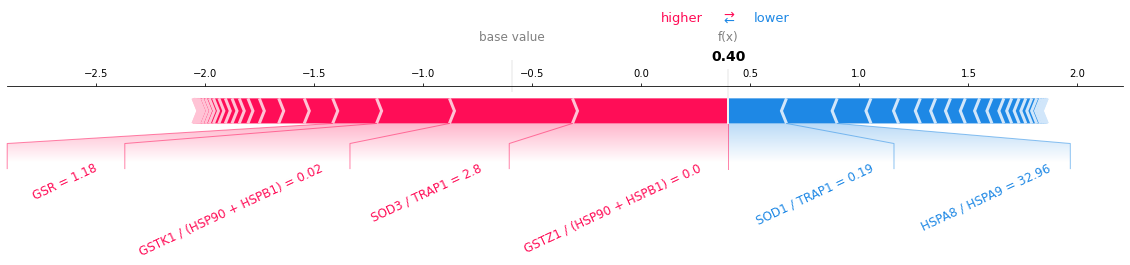

None

In [94]:
for name in  ["xgb_binary_no_energy", "xgb_multi_no_energy", "xgb_multi_energy"]:
    print( 2*"\n" + 50 * "=")
    print(10*"=" + f"   {name}   " + 10*"=")
    print(50 * "=")
    
    selected_model_results = MODEL_RESULTS[name] 
    best_score_idx = selected_model_results["fs_scores"].idxmax()
    best_features = selected_model_results["fs_features"][best_score_idx]
    best_model = selected_model_results["fs_pipes"][best_score_idx]["model"]

    best_worst_df = best_worst_preds(
        best_model,
        DATA[name]["X"][best_features],
        DATA[name]["y"],
        DATA[name]["category_encoder"],
        cv_splitter
    )

    best_worst_by_category = (
        best_worst_df
        .groupby("y")
        .apply(lambda df: df.sort_values("log_loss").iloc[[0, -1]])
        .reset_index("y",drop=True)
    )

    best_worst_force_plots(
        best_model,
        DATA[name]["X"][best_features],
        DATA[name]["y"],
        best_worst_by_category,
        DATA[name]["category_encoder"],
        cv_splitter,
        #save_name=name
    )

BC
CCA
CRC
CTL
EC
GC
LC
LD


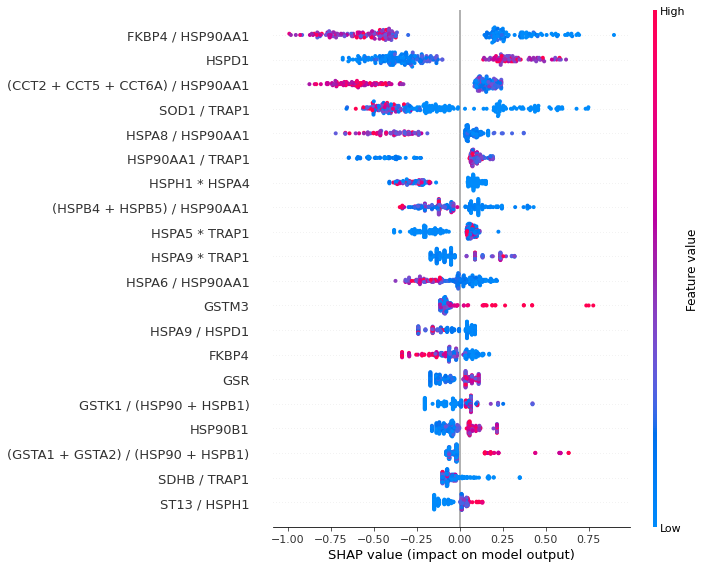

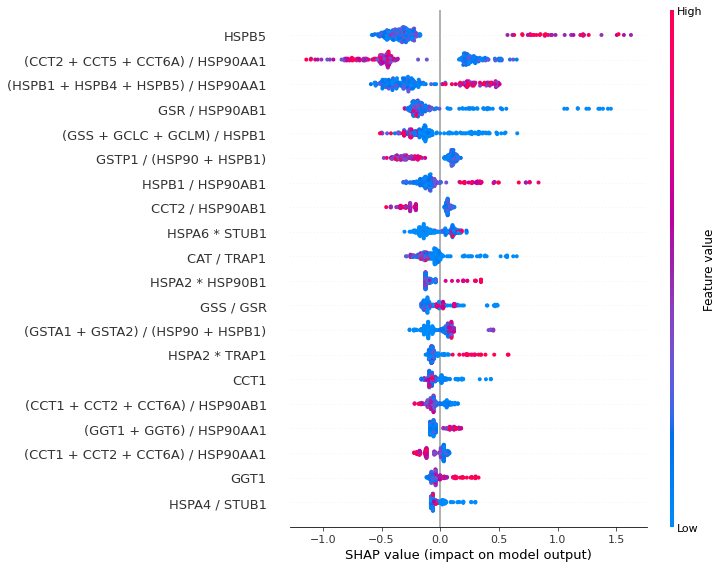

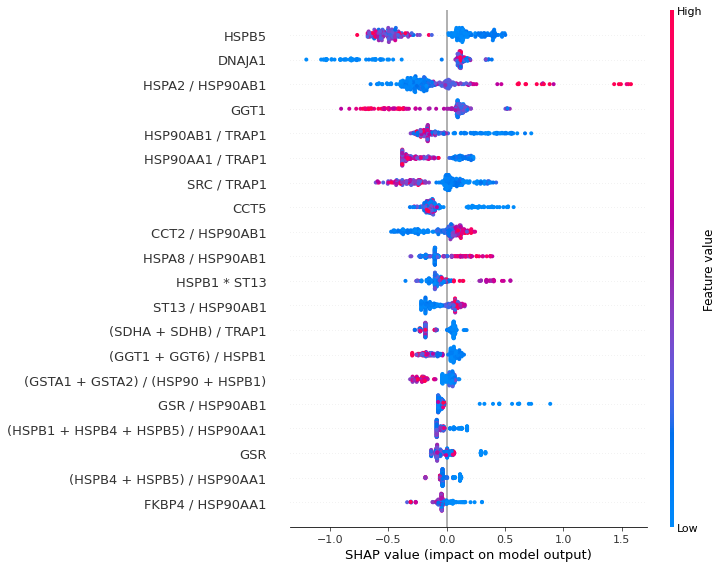

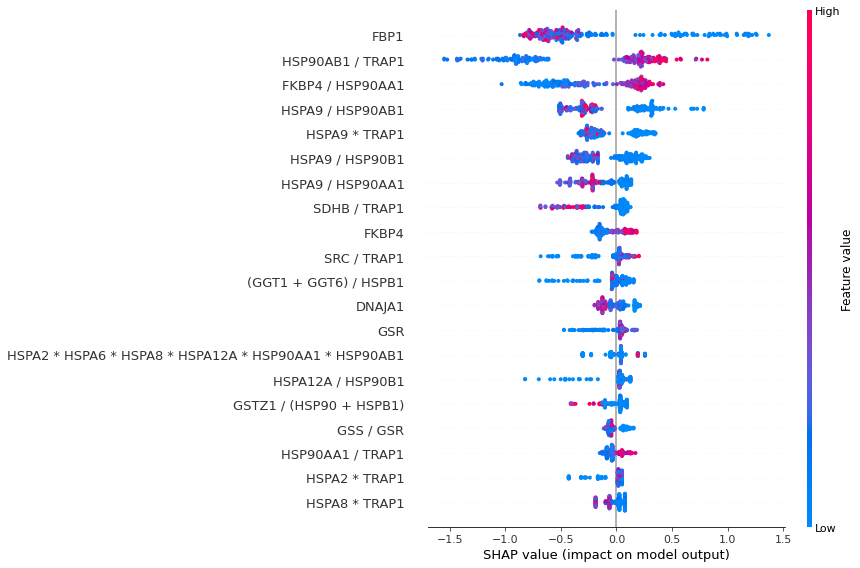

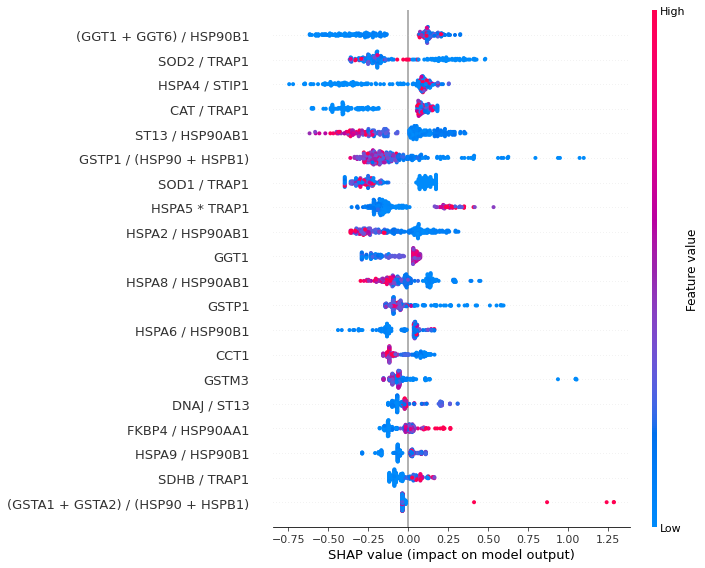

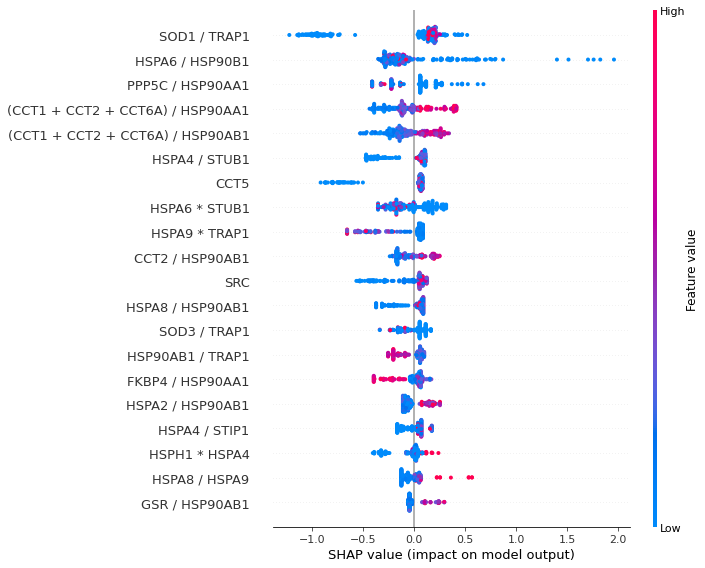

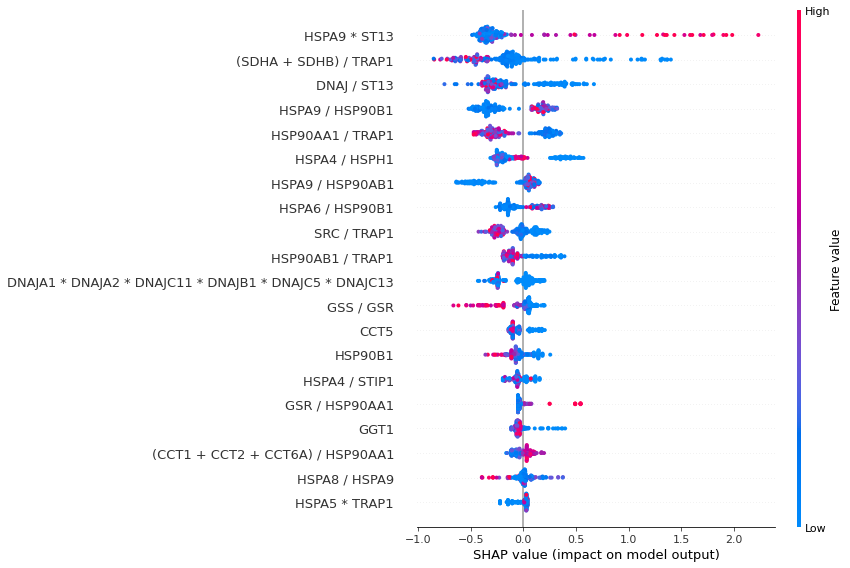

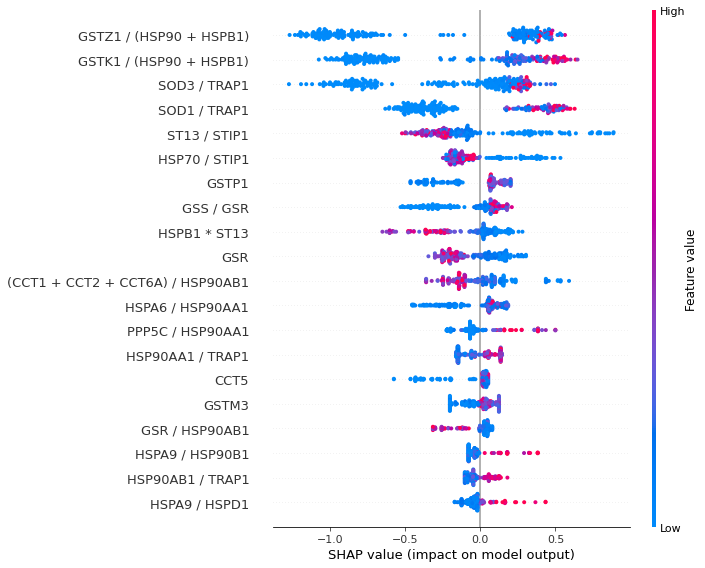

In [92]:
save = True

for name in  ["xgb_binary_no_energy", "xgb_multi_no_energy", "xgb_multi_energy"]:
    print( 2*"\n" + 50 * "=")
    print(10*"=" + f"   {name}   " + 10*"=")
    print(50 * "=")
    
    selected_model_results = MODEL_RESULTS[name] 
    best_score_idx = selected_model_results["fs_scores"].idxmax()
    best_features = selected_model_results["fs_features"][best_score_idx]
    best_model = selected_model_results["fs_pipes"][best_score_idx]["model"]
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(DATA[name]["X"][best_features])
    for category, category_shap_values in zip(DATA[name]["category_encoder"].classes_, shap_values):
        print(category)
        fig, ax = plt.subplots(figsize=(8,8))
        shap.summary_plot(
            category_shap_values,
            DATA[name]["X"][best_features].rename(columns=CLEAN_EQUATION_MAPPING),
            show=False if save else True
        )

        if save:
            plt.savefig(
                os.path.join(SHAP_DIR, name, f"shap_summary_category_{category}.png"),
                dpi=300,
                bbox_inches='tight'
            )

In [ ]:
#explainer = shap.Explainer(clone(best_model).fit(DATA[name]["X"], DATA[name]["y"]))
#shap_values = explainer(DATA[name]["X"])
#shap.plots.waterfall(shap_values[0])